In [1]:
import pandas as pd
import numpy as np

# Assuming data is in 'smuggling_data.csv'
df = pd.read_csv('smuggling_data.csv')
# If directly from the image, manually create DataFrame or use OCR tool output

In [2]:
print(df.head())
print(df.info()) # Check data types, non-null counts
print(df.describe(include='all')) # Get stats for numerical and categorical features

   location                 date  smuggling_incident weather_condition  \
0  Border B  2022-01-17 10:23:58                   1             storm   
1  Border D  2020-05-01 13:51:08                   0             sunny   
2  Border A  2022-01-03 01:23:15                   1             storm   
3  Border C  2020-12-10 02:10:24                   0               fog   
4  Border D  2022-11-27 15:37:01                   0             storm   

  geopolitical_event terrain_type  poverty_rate  distance_to_checkpoint  \
0           conflict   water_body     20.710303               30.619974   
1               none       forest     37.106773               19.778847   
2          sanctions     mountain     47.601203                3.823847   
3      trade_dispute       forest     24.796979               17.471272   
4      trade_dispute       forest     29.805891               42.944101   

   population_density  
0          319.632157  
1          541.366223  
2          963.310087  
3       

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S') # Adjust format if needed
df = df.sort_values(by='date').reset_index(drop=True) # Sort chronologically

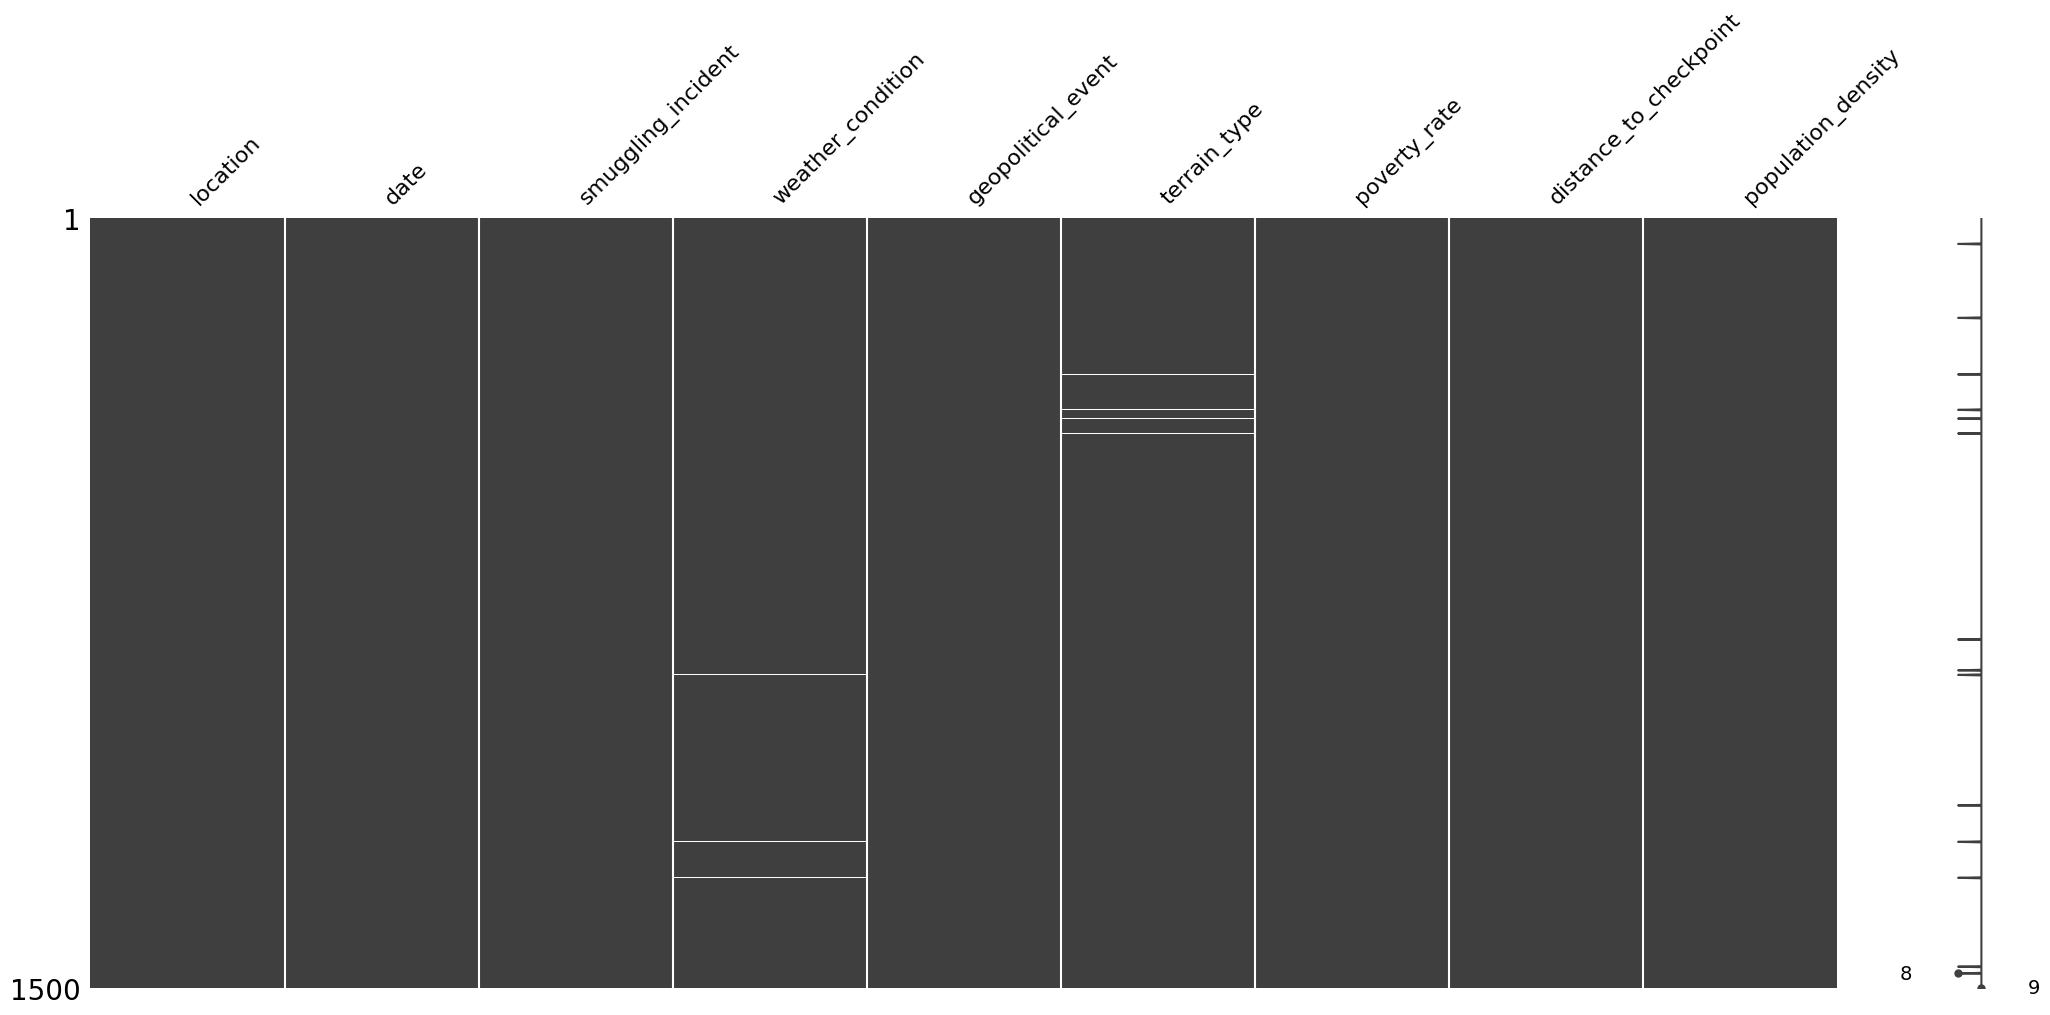

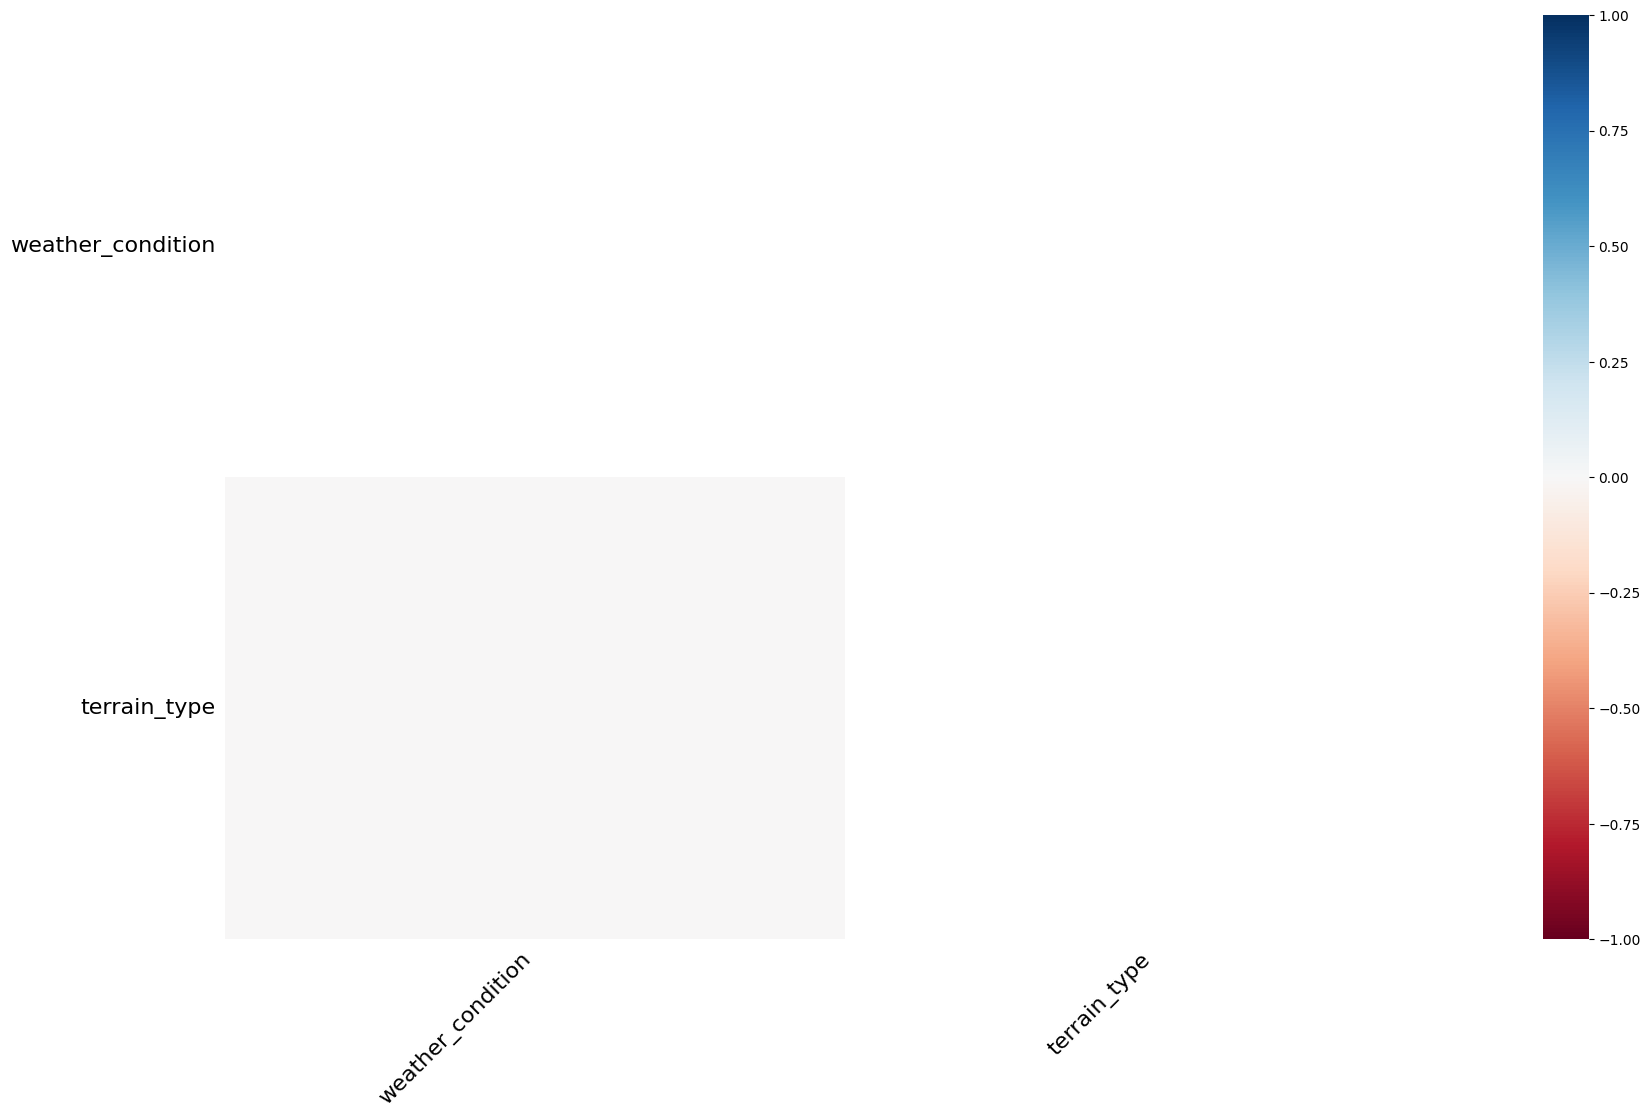

In [4]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()
msno.heatmap(df)
plt.show()
# Decide on an imputation strategy if missing values exist (e.g., mean/median/mode, KNNImputer, or model-based)

smuggling_incident
0    0.694
1    0.306
Name: proportion, dtype: float64


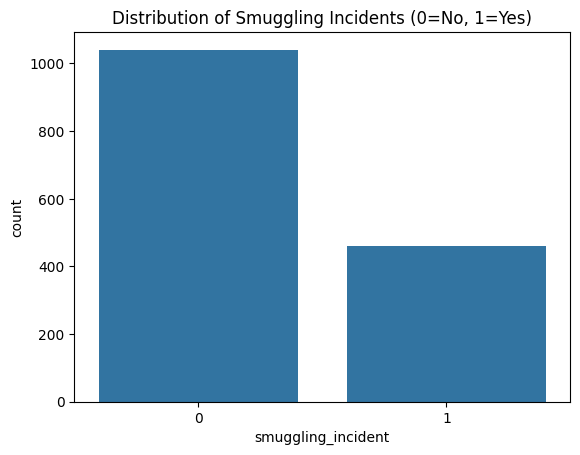

In [5]:
import seaborn as sns

print(df['smuggling_incident'].value_counts(normalize=True))
sns.countplot(x='smuggling_incident', data=df)
plt.title('Distribution of Smuggling Incidents (0=No, 1=Yes)')
plt.show()
# Check for class imbalance - crucial for classification!

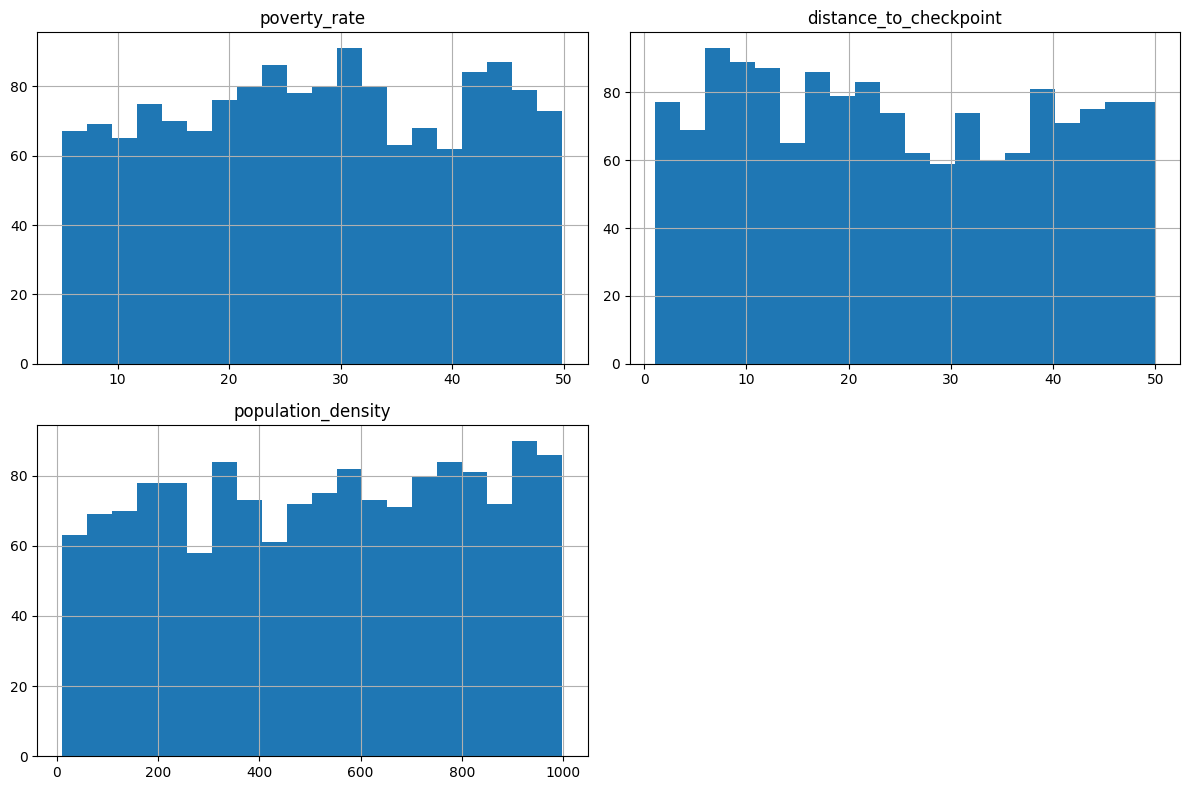

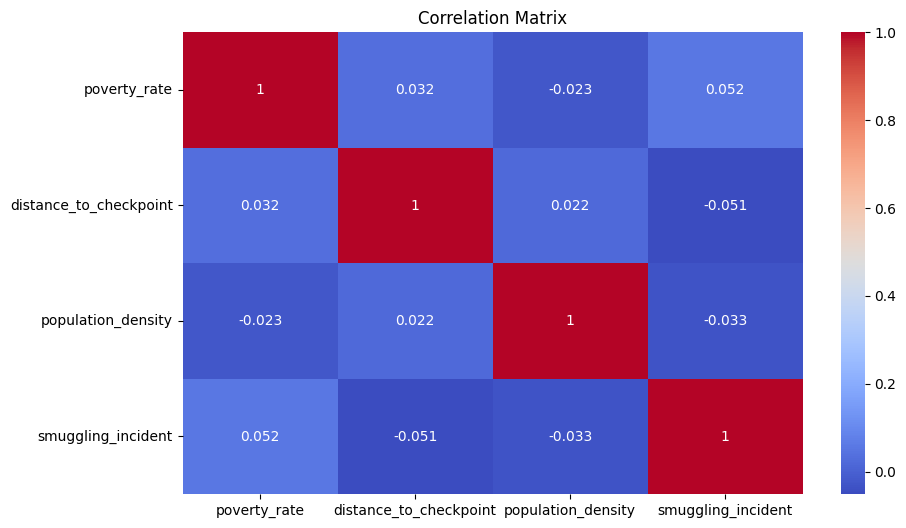

In [6]:
numerical_cols = ['poverty_rate', 'distance_to_checkpoint', 'population_density']
df[numerical_cols].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols + ['smuggling_incident']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

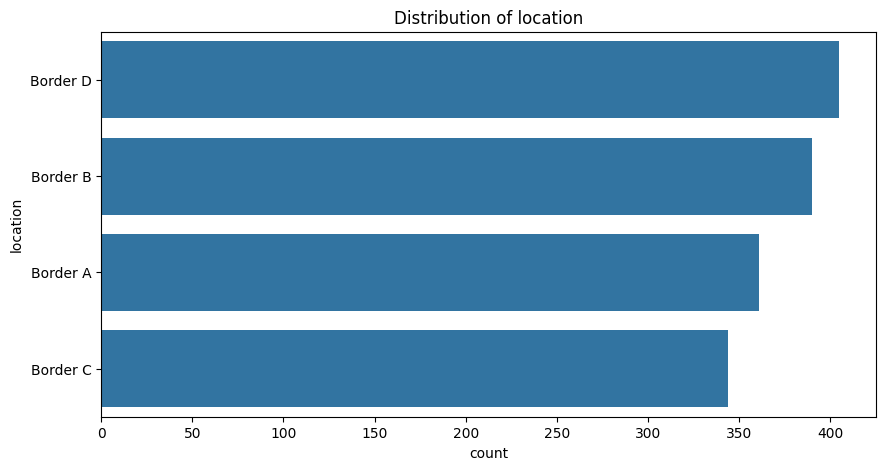

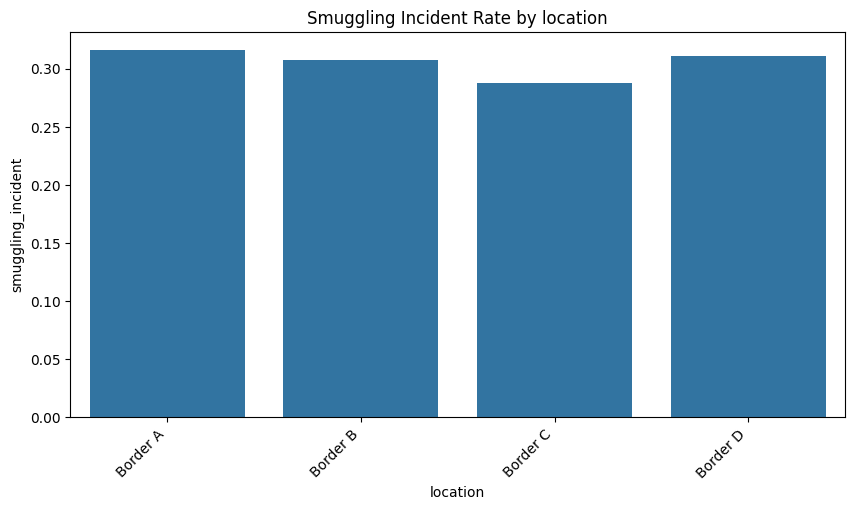

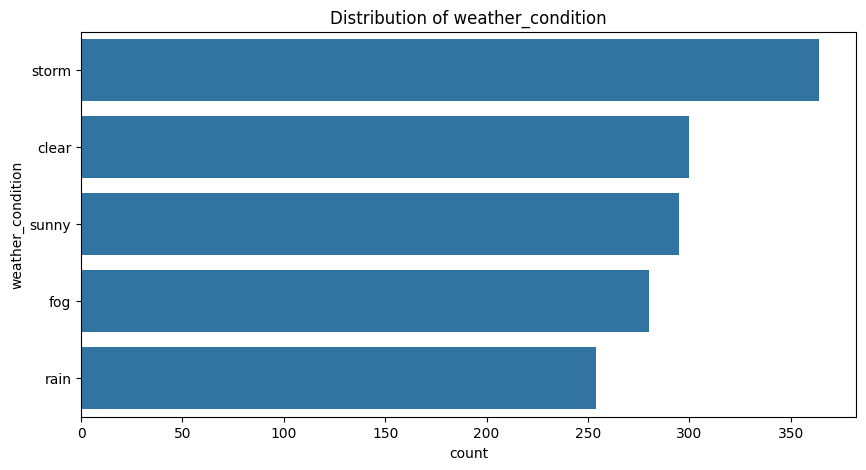

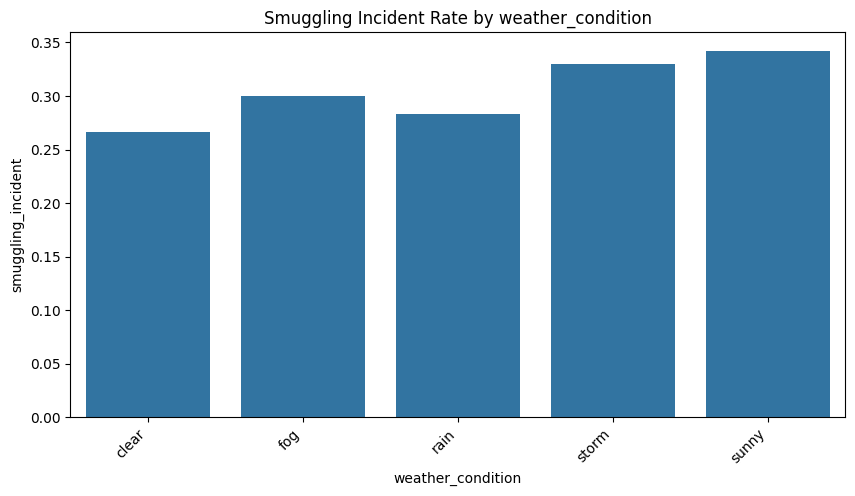

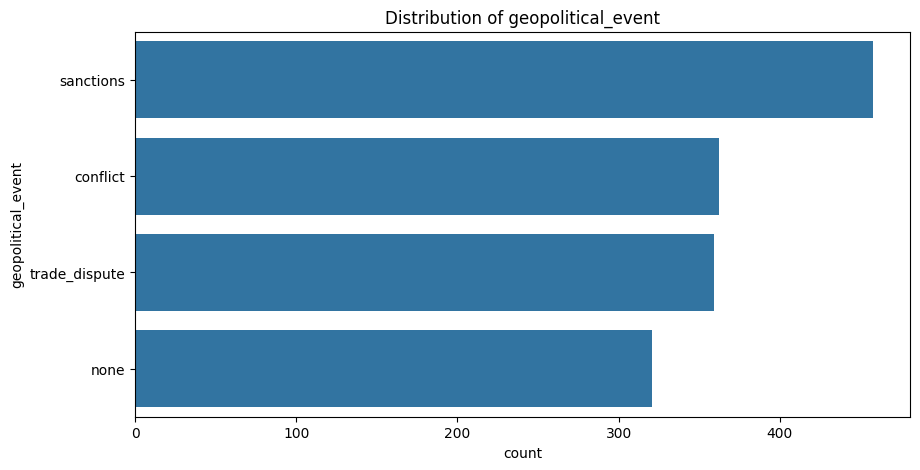

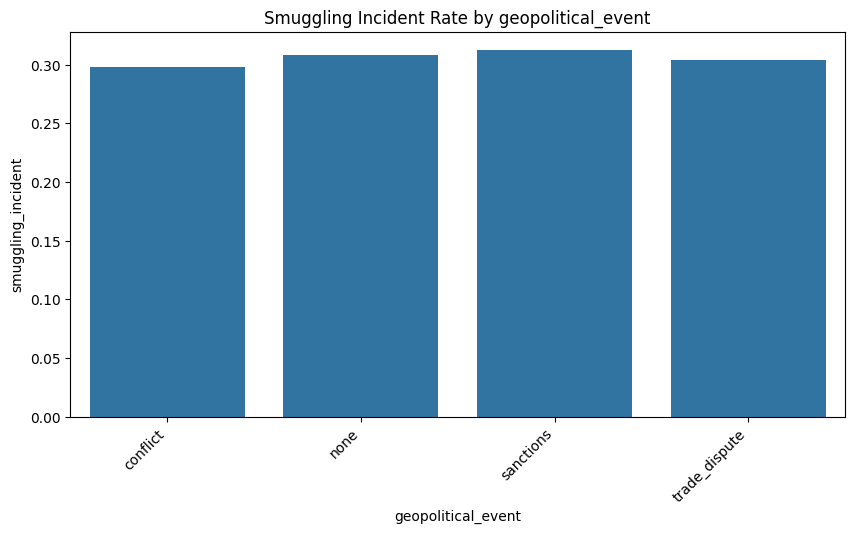

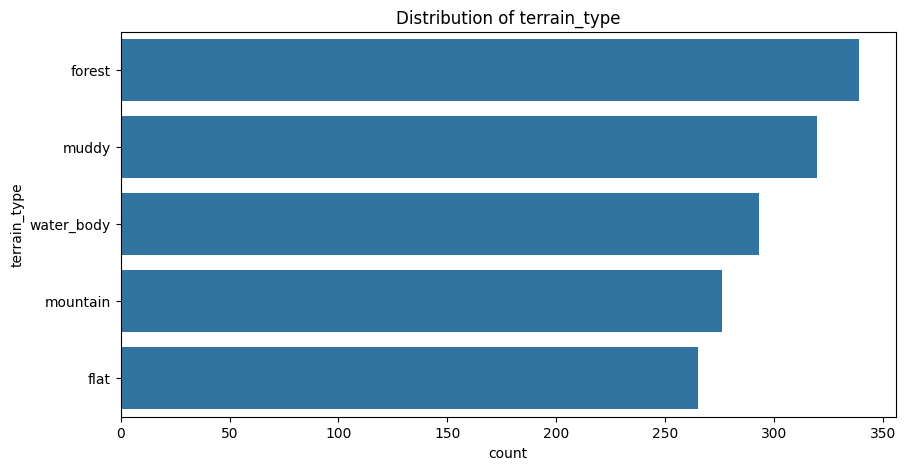

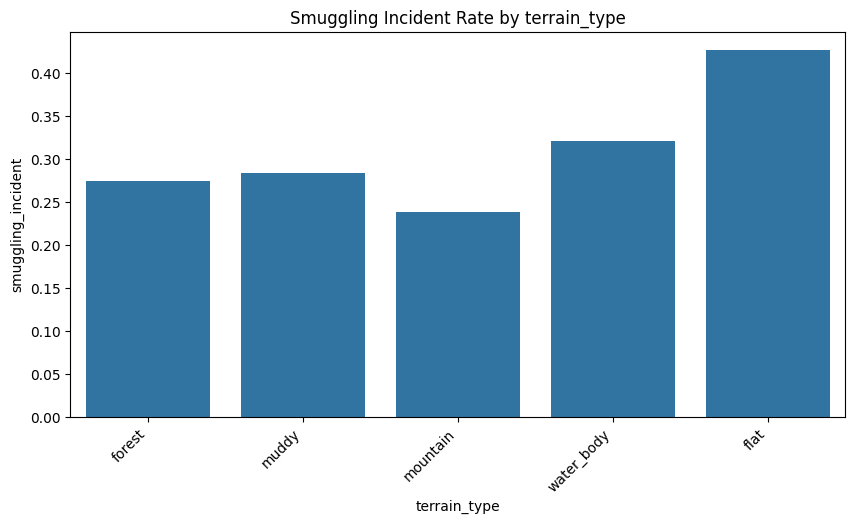

In [7]:
categorical_cols = ['location', 'weather_condition', 'geopolitical_event', 'terrain_type']
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y='smuggling_incident', data=df, errorbar=None) # Use error bars if desired
    plt.title(f'Smuggling Incident Rate by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

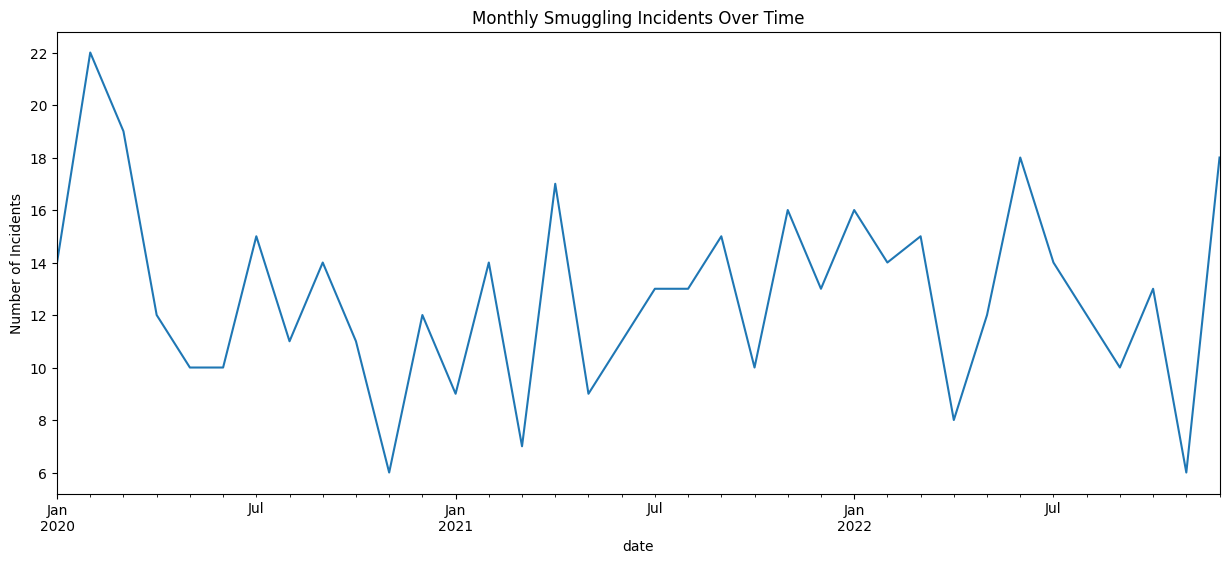

In [8]:
df.set_index('date')['smuggling_incident'].resample('ME').sum().plot(figsize=(15, 6)) # Monthly counts
plt.title('Monthly Smuggling Incidents Over Time')
plt.ylabel('Number of Incidents')
plt.show()

In [9]:
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
# Potentially: 'is_weekend', 'time_of_day' (night, morning, afternoon, evening)

In [10]:
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # drop_first avoids multicollinearity

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Scaler will be fitted *only* on training data later
scaler = StandardScaler()
numerical_cols_to_scale = numerical_cols + ['hour', 'day_of_week', 'day_of_month', 'month', 'year'] # Add derived numerical features

In [12]:
from sklearn.model_selection import train_test_split

# Example: Use the last 20% of data for testing
test_size = int(len(df_processed) * 0.2)
train_df = df_processed[:-test_size]
test_df = df_processed[-test_size:]

X_train = train_df.drop(['smuggling_incident', 'date'], axis=1) # Drop the original date and target
y_train = train_df['smuggling_incident']
X_test = test_df.drop(['smuggling_incident', 'date'], axis=1)
y_test = test_df['smuggling_incident']

# Fit and transform scaler *after* splitting
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale]) # Use transform only

# Make sure columns are aligned if using get_dummies
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [13]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
# Evaluate baseline performance

DummyClassifier(strategy='most_frequent')

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


# Model definitions (using default parameters initially)
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced') # Example using class weight
svm_clf = SVC(probability=True, random_state=42, class_weight='balanced') # probability=True for AUC/probabilities
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train) ) # Example scale_pos_weight for imbalance

lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
cat_clf = cb.CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')



models = {
    "Random Forest": rf_clf,
    "SVM": svm_clf,
    "XGBoost": xgb_clf,
    "LightGBM": lgb_clf,
    "CatBoost": cat_clf
}

# Train models (use resampled data if SMOTE was applied)
for name, model in models.items():
    print(f"Training {name}...")
    # model.fit(X_train_resampled, y_train_resampled) # If using SMOTE
    model.fit(X_train, y_train) # If using class weights or no balancing needed

Training Random Forest...
Training SVM...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 371, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training CatBoost...



--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       212
           1       0.67      0.02      0.04        88

    accuracy                           0.71       300
   macro avg       0.69      0.51      0.44       300
weighted avg       0.70      0.71      0.60       300

ROC AUC: 0.5273
PR AUC: 0.3241


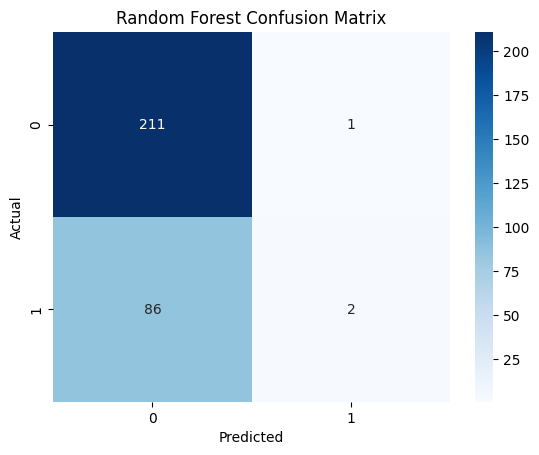


--- SVM Evaluation ---
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       212
           1       0.36      0.43      0.39        88

    accuracy                           0.61       300
   macro avg       0.55      0.56      0.55       300
weighted avg       0.63      0.61      0.62       300

ROC AUC: 0.5999
PR AUC: 0.3735


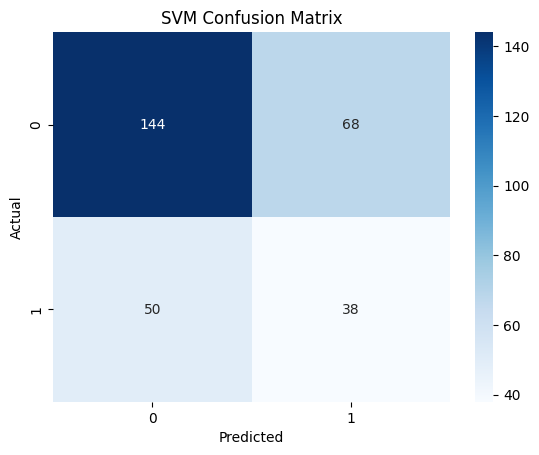


--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       212
           1       0.32      0.25      0.28        88

    accuracy                           0.63       300
   macro avg       0.52      0.52      0.51       300
weighted avg       0.60      0.63      0.61       300

ROC AUC: 0.5162
PR AUC: 0.3072


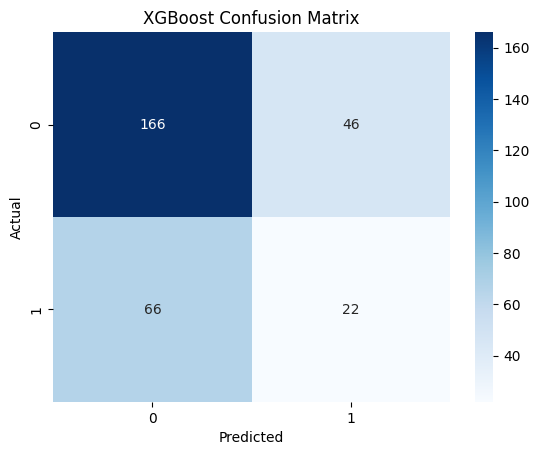


--- LightGBM Evaluation ---
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       212
           1       0.31      0.30      0.30        88

    accuracy                           0.60       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.60      0.60      0.60       300

ROC AUC: 0.4931
PR AUC: 0.2947


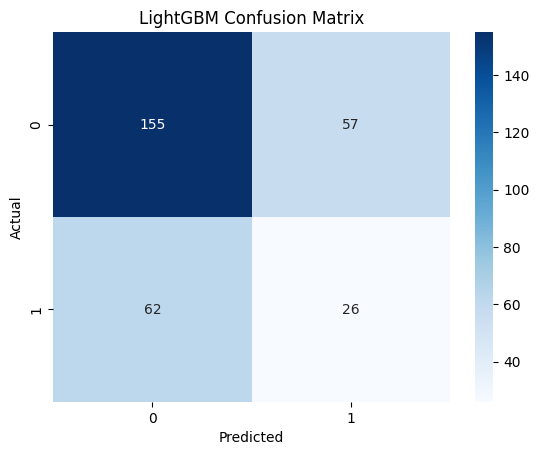


--- CatBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       212
           1       0.22      0.15      0.18        88

    accuracy                           0.60       300
   macro avg       0.45      0.47      0.45       300
weighted avg       0.55      0.60      0.57       300

ROC AUC: 0.5153
PR AUC: 0.2928


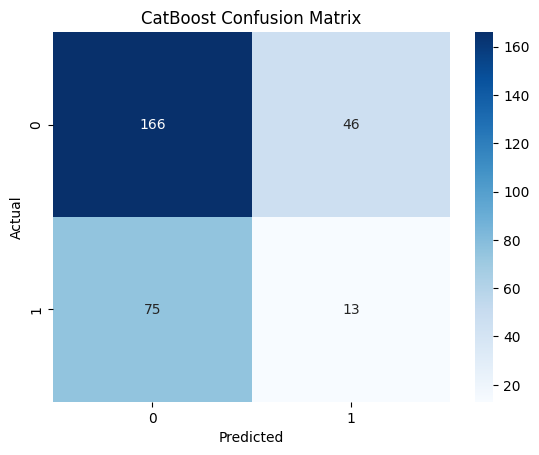

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of positive class

    print(f"\n--- {name} Evaluation ---")
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Store results for comparison
    results[name] = {'roc_auc': roc_auc, 'pr_auc': pr_auc, 'f1_score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']}

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [16]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb # Ensure xgboost is imported if not already
import numpy as np # Ensure numpy is imported for sum()

# Example for XGBoost
tscv = TimeSeriesSplit(n_splits=5)
param_dist = {
    'n_estimators': [50,100,150,200,250,300,350,500],
    'learning_rate': [0.01,0.03, 0.05,0.07, 0.1],
    'max_depth': [2,3, 4,5,6 ,7,8, 9,10],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Corrected parameter name

}

# Remember to keep scale_pos_weight if needed
# Removed use_label_encoder=False
# Ensure y_train is defined and accessible here
scale_pos_weight_value = (len(y_train) - np.sum(y_train)) / np.sum(y_train) if np.sum(y_train) > 0 else 1
xgb_clf_tuned = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value)

random_search = RandomizedSearchCV(
    xgb_clf_tuned, param_distributions=param_dist, n_iter=50, # Number of iterations
    scoring='roc_auc', # Or 'average_precision' for PR AUC
    cv=tscv,
    n_jobs=1, # Changed to 1 based on the previous successful run
    random_state=42, verbose=2
)

# Fit on the *entire* training set (or the appropriate resampled version)
# Ensure X_train and y_train are defined and accessible here
random_search.fit(X_train, y_train) # Or X_train_resampled, y_train_resampled

print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=350, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=350, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=350, subsample=0.6; total time=   0.1s
[CV] END c

Best parameters found for XGBoost:  {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.07, 'colsample_bytree': 0.7}

--- Best XGBoost Model Evaluation ---
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       212
           1       0.28      0.42      0.34        88

    accuracy                           0.51       300
   macro avg       0.49      0.49      0.48       300
weighted avg       0.57      0.51      0.53       300

ROC AUC (XGBoost): 0.4967
PR AUC (XGBoost): 0.2794


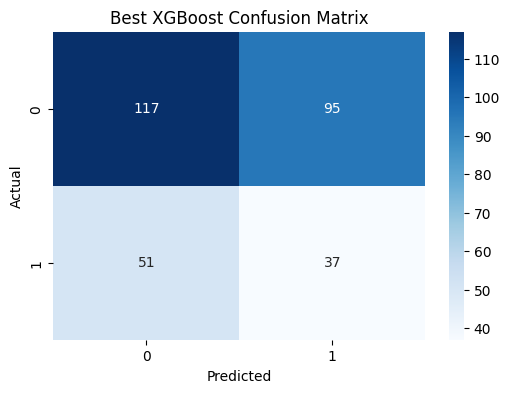

In [17]:
print("Best parameters found for XGBoost: ", random_search.best_params_)
best_xgb_model = random_search.best_estimator_ # Get the best XGBoost model

# --- Now, explicitly evaluate this best XGBoost model ---
print("\n--- Best XGBoost Model Evaluation ---")
y_pred_xgb = best_xgb_model.predict(X_test)
try:
    y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Probability of positive class
except AttributeError: # Some models might not have predict_proba readily available after certain operations
    print("Could not get probabilities for XGBoost, calculating ROC AUC based on decisions.")
    # Use decision_function if available, otherwise ROC AUC might not be calculable this way
    try:
         y_proba_xgb = best_xgb_model.decision_function(X_test)
         # Adjust for decision function range if needed, or just use for ranking
    except AttributeError:
         y_proba_xgb = None # Cannot calculate ROC AUC or PR AUC without probabilities/scores

# Print classification report
print(classification_report(y_test, y_pred_xgb))

# Calculate and print AUC scores if probabilities/scores are available
if y_proba_xgb is not None:
    try:
        roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
        precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
        pr_auc_xgb = auc(recall_xgb, precision_xgb)
        print(f"ROC AUC (XGBoost): {roc_auc_xgb:.4f}")
        print(f"PR AUC (XGBoost): {pr_auc_xgb:.4f}")
    except ValueError as e:
        print(f"Could not calculate AUC scores for XGBoost: {e}")
else:
     print("AUC scores cannot be calculated for XGBoost as probabilities/scores are unavailable.")


# Display Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4)) # Create a new figure for the heatmap
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Best XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() # Display the plot

In [18]:
print("Best ROC AUC score: ", random_search.best_score_)

Best ROC AUC score:  0.5240304389503933


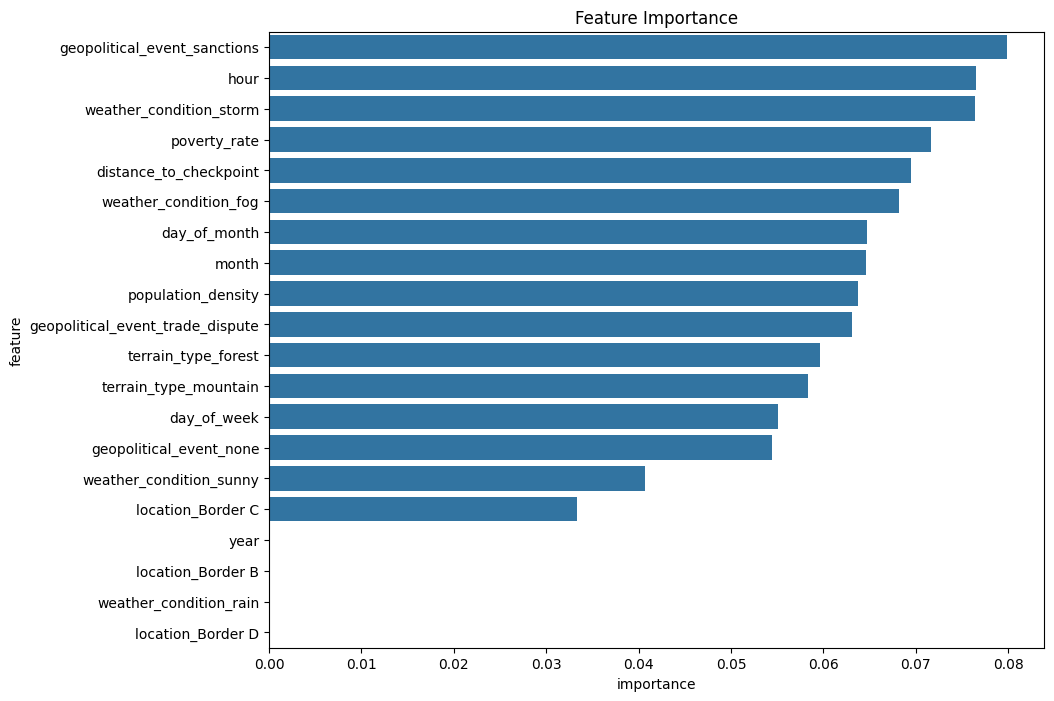

In [19]:
# For tree-based models (RF, XGB, LGB, CatBoost)
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Top 20 features
plt.title('Feature Importance')
plt.show()

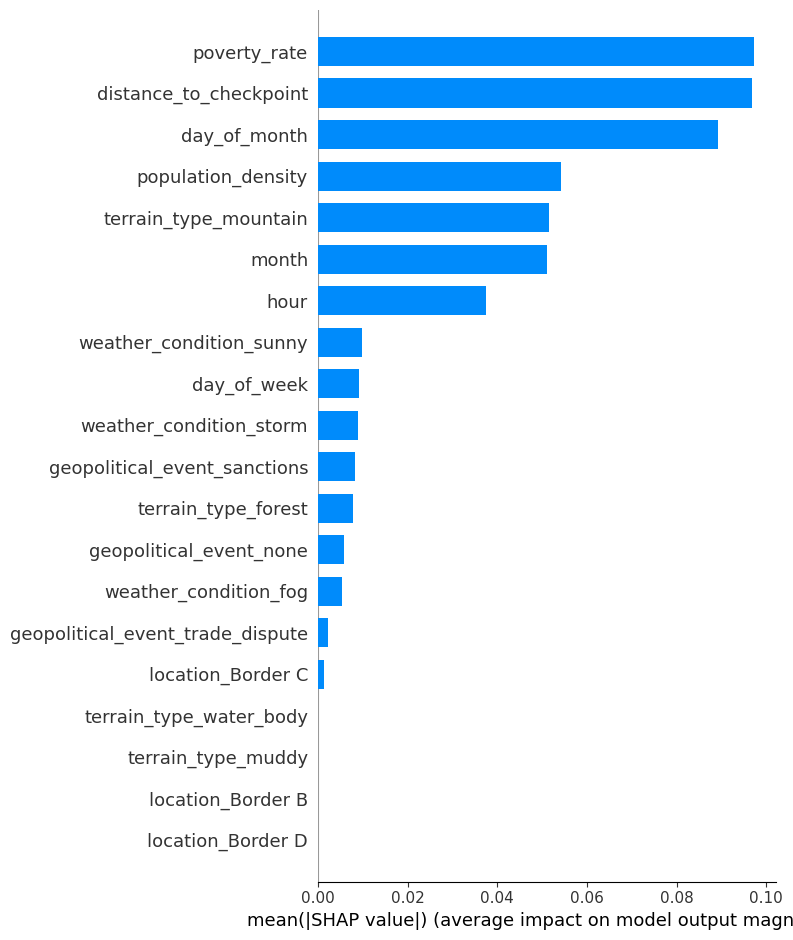

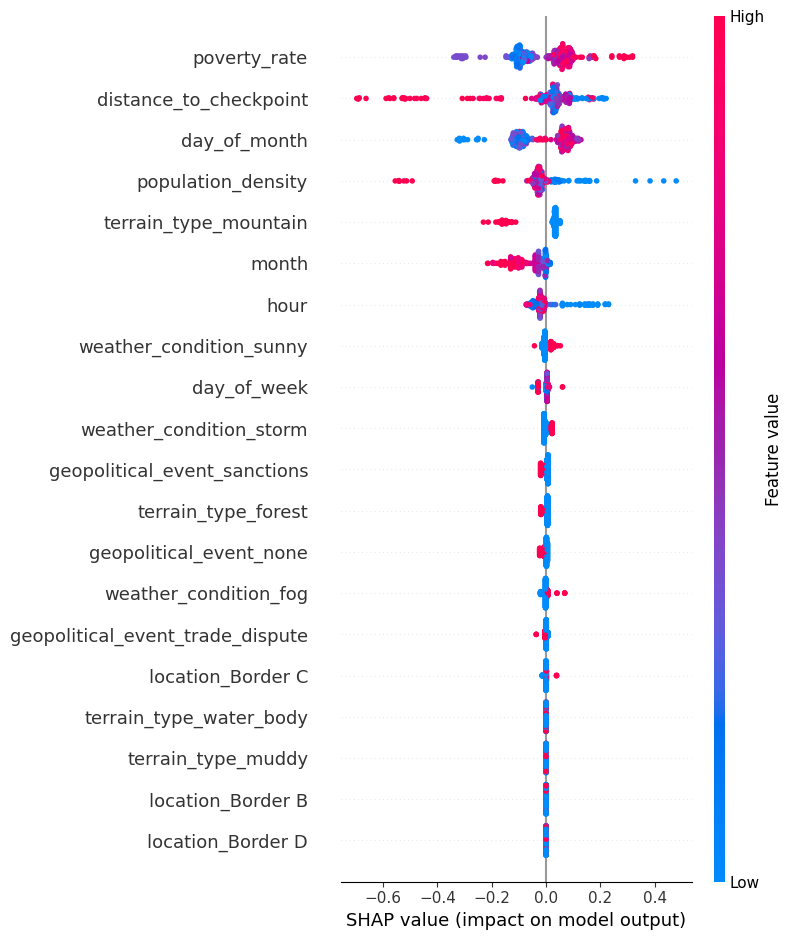

In [20]:
import shap

explainer = shap.TreeExplainer(best_model) # Use appropriate explainer for model type
shap_values = explainer.shap_values(X_test) # Use test set for insights on unseen data

shap.summary_plot(shap_values, X_test, plot_type="bar") # Overall feature importance
shap.summary_plot(shap_values, X_test) # Beeswarm plot showing direction and magnitude
# Explore individual predictions: shap.force_plot(...)
# Explore feature dependencies: shap.dependence_plot(...)

In [21]:
#using smot from here

In [22]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
# You might need to adjust sampling_strategy if default (balancing completely) isn't desired
smote = SMOTE(random_state=42)

print("\nApplying SMOTE to training data...")
# Apply SMOTE ONLY to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Applying SMOTE to training data...


c:\Users\Satyam\miniconda3\envs\mini_project\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training models on SMOTE resampled data...
Training Random Forest (SMOTE)...
Training SVM (SMOTE)...
Training XGBoost (SMOTE)...
Training LightGBM (SMOTE)...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 829, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1658, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training CatBoost (SMOTE)...


c:\Users\Satyam\miniconda3\envs\mini_project\lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.

--- Model Evaluation (on original Test Set) ---

--- Random Forest (SMOTE) Evaluation ---
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       212
           1       0.34      0.15      0.21        88

    accuracy                           0.67       300
   macro avg       0.53      0.51      0.50       300
weighted avg       0.60      0.67      0.62       300

ROC AUC: 0.5303
PR AUC: 0.3193


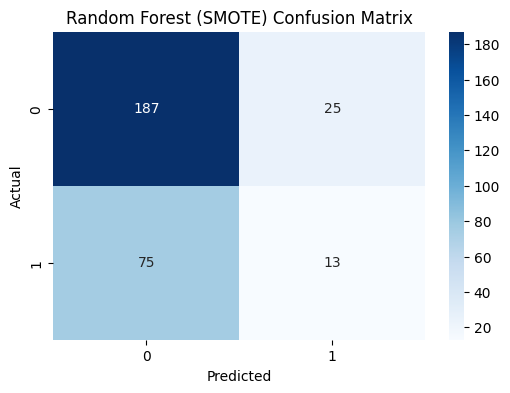


--- SVM (SMOTE) Evaluation ---
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       212
           1       0.37      0.22      0.27        88

    accuracy                           0.66       300
   macro avg       0.54      0.53      0.52       300
weighted avg       0.62      0.66      0.63       300

ROC AUC: 0.5579
PR AUC: 0.3601


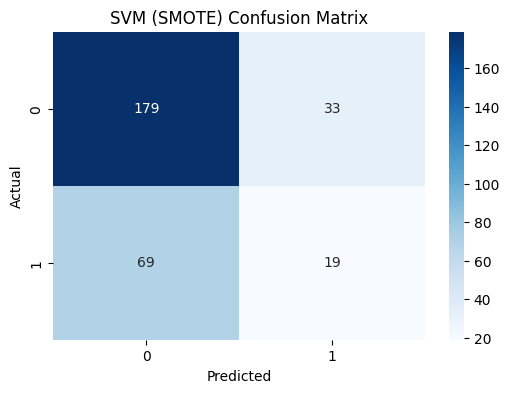


--- XGBoost (SMOTE) Evaluation ---
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       212
           1       0.26      0.17      0.21        88

    accuracy                           0.62       300
   macro avg       0.48      0.49      0.48       300
weighted avg       0.57      0.62      0.59       300

ROC AUC: 0.5207
PR AUC: 0.3042


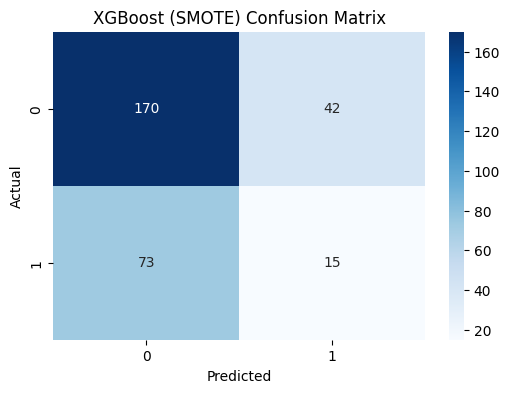


--- LightGBM (SMOTE) Evaluation ---
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       212
           1       0.34      0.24      0.28        88

    accuracy                           0.64       300
   macro avg       0.53      0.52      0.52       300
weighted avg       0.61      0.64      0.62       300

ROC AUC: 0.5211
PR AUC: 0.3248


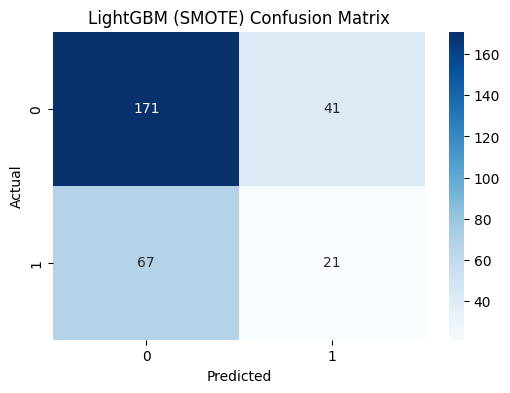


--- CatBoost (SMOTE) Evaluation ---
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       212
           1       0.39      0.16      0.23        88

    accuracy                           0.68       300
   macro avg       0.55      0.53      0.51       300
weighted avg       0.62      0.68      0.63       300

ROC AUC: 0.5506
PR AUC: 0.3177


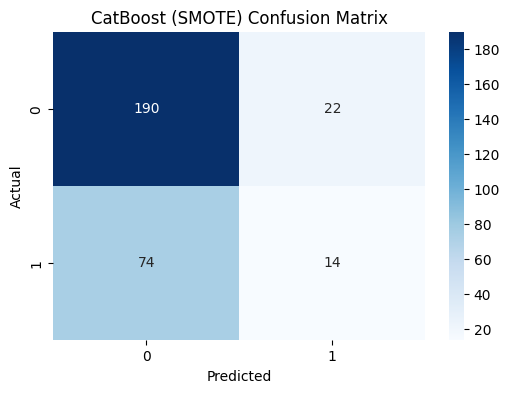

In [23]:
# Redefine them WITHOUT the class weighting parameters:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

rf_clf_smote = RandomForestClassifier(random_state=42) # No class_weight
svm_clf_smote = SVC(probability=True, random_state=42) # No class_weight
xgb_clf_smote = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # No scale_pos_weight
lgb_clf_smote = lgb.LGBMClassifier(random_state=42) # No class_weight / is_unbalance
cat_clf_smote = cb.CatBoostClassifier(random_state=42, verbose=0) # No auto_class_weights

models_smote = {
    "Random Forest (SMOTE)": rf_clf_smote,
    "SVM (SMOTE)": svm_clf_smote,
    "XGBoost (SMOTE)": xgb_clf_smote,
    "LightGBM (SMOTE)": lgb_clf_smote,
    "CatBoost (SMOTE)": cat_clf_smote
}

# Train models on the RESAMPLED data
print("\nTraining models on SMOTE resampled data...")
for name, model in models_smote.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled) # Use X_train_resampled, y_train_resampled
print("Model training complete.")


# --- Model Evaluation (Using Original Test Data) ---
# Evaluation ALWAYS happens on the original, untouched test set
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Model Evaluation (on original Test Set) ---")
results_smote = {}
for name, model in models_smote.items():
    # Predict on the ORIGINAL X_test
    y_pred = model.predict(X_test)
    try:
         # Use predict_proba for AUC scores if available
         y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
         y_proba = None # Cannot calculate AUC scores

    print(f"\n--- {name} Evaluation ---")
    print(classification_report(y_test, y_pred)) # Evaluate against y_test

    if y_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            pr_auc = auc(recall, precision)
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"PR AUC: {pr_auc:.4f}")
            results_smote[name] = {'roc_auc': roc_auc, 'pr_auc': pr_auc, 'f1_score_class1': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']}
        except ValueError as e:
            print(f"Could not calculate AUC scores: {e}")
            results_smote[name] = {'roc_auc': None, 'pr_auc': None, 'f1_score_class1': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']}

    else:
        print("AUC scores cannot be calculated as predict_proba is unavailable.")
        results_smote[name] = {'roc_auc': None, 'pr_auc': None, 'f1_score_class1': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']}


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4)) # Ensure a new figure is created for each matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show() # Display the

In [24]:
# CatBoost Hyperparameter Tuning
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import catboost as cb
import numpy as np

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the hyperparameter search space for CatBoost
catboost_param_dist = {
    'iterations': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1, 2, 5, 10],
    'random_strength': [0, 0.5, 1, 2],
    'one_hot_max_size': [0, 10, 25, 50, 100, 200],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Create base CatBoost classifier (no class weights since we'll evaluate against the SMOTE version)
catboost_tuned = cb.CatBoostClassifier(
    random_state=42,
    verbose=0,  # Set to 100 for more information during training
    eval_metric='AUC',
    auto_class_weights='Balanced'  # CatBoost handles class imbalance
)

# Create the randomized search
catboost_random_search = RandomizedSearchCV(
    catboost_tuned, 
    param_distributions=catboost_param_dist, 
    n_iter=30,  # Number of parameter settings sampled
    scoring='roc_auc',  # Metric to optimize
    cv=tscv,
    n_jobs=1,  # Adjust based on your system capabilities
    random_state=42, 
    verbose=2
)

# Fit on the training set
print("Starting CatBoost hyperparameter tuning...")
catboost_random_search.fit(X_train, y_train)

print("Best parameters found for CatBoost: ", catboost_random_search.best_params_)
best_catboost_model = catboost_random_search.best_estimator_

Starting CatBoost hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bagging_temperature=5, border_count=128, depth=8, iterations=700, l2_leaf_reg=5, learning_rate=0.01, one_hot_max_size=50, random_strength=1, subsample=0.6; total time=   1.5s
[CV] END bagging_temperature=5, border_count=128, depth=8, iterations=700, l2_leaf_reg=5, learning_rate=0.01, one_hot_max_size=50, random_strength=1, subsample=0.6; total time=   1.6s
[CV] END bagging_temperature=5, border_count=128, depth=8, iterations=700, l2_leaf_reg=5, learning_rate=0.01, one_hot_max_size=50, random_strength=1, subsample=0.6; total time=   1.7s
[CV] END bagging_temperature=5, border_count=128, depth=8, iterations=700, l2_leaf_reg=5, learning_rate=0.01, one_hot_max_size=50, random_strength=1, subsample=0.6; total time=   1.7s
[CV] END bagging_temperature=5, border_count=128, depth=8, iterations=700, l2_leaf_reg=5, learning_rate=0.01, one_hot_max_size=50, random_strength=1, subsample


--- Best CatBoost Model Evaluation ---
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       212
           1       0.31      0.34      0.33        88

    accuracy                           0.59       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.60      0.59      0.59       300

ROC AUC (CatBoost): 0.5455
PR AUC (CatBoost): 0.3017


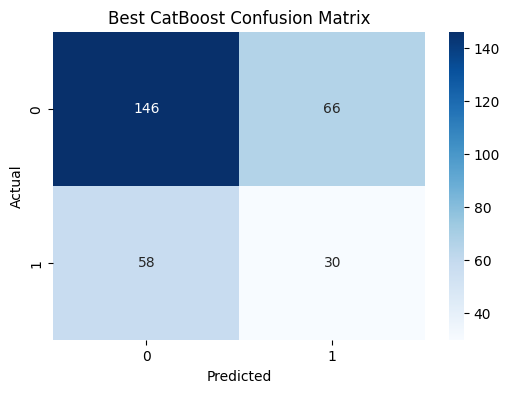

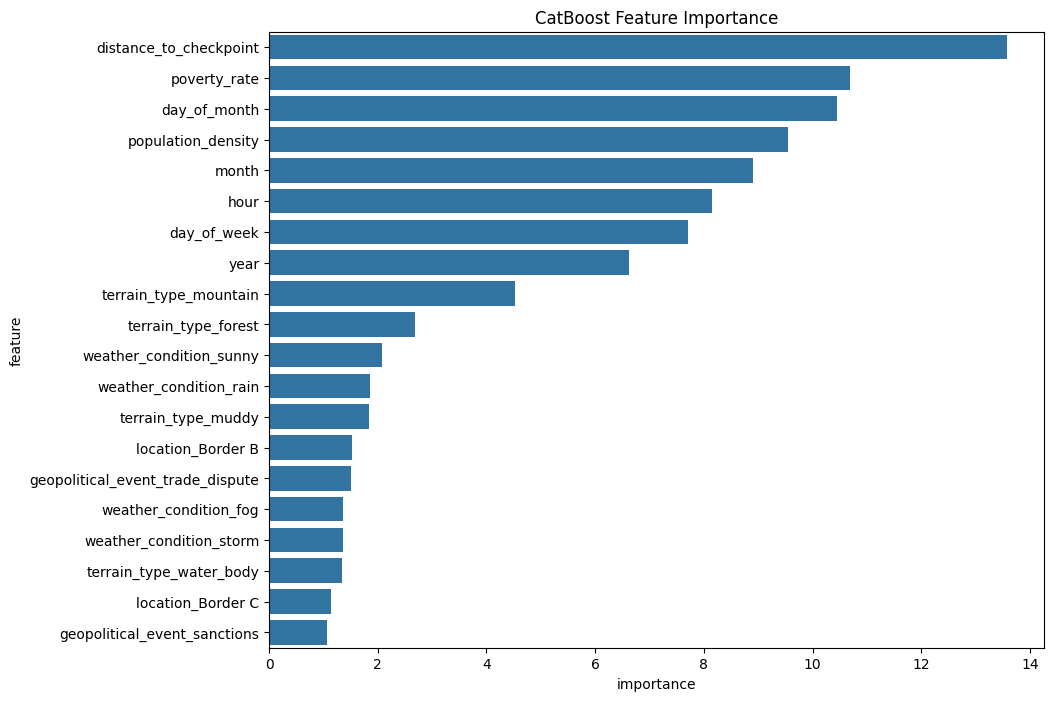

In [25]:
# Evaluate the best CatBoost model
print("\n--- Best CatBoost Model Evaluation ---")
y_pred_catboost = best_catboost_model.predict(X_test)
y_proba_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

# Print classification metrics
print(classification_report(y_test, y_pred_catboost))

# Calculate and print AUC scores
roc_auc_catboost = roc_auc_score(y_test, y_proba_catboost)
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, y_proba_catboost)
pr_auc_catboost = auc(recall_catboost, precision_catboost)
print(f"ROC AUC (CatBoost): {roc_auc_catboost:.4f}")
print(f"PR AUC (CatBoost): {pr_auc_catboost:.4f}")

# Display Confusion Matrix
cm_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
plt.title('Best CatBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance for CatBoost
feature_importance = best_catboost_model.feature_importances_
feature_names = X_train.columns
catboost_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
catboost_importance_df = catboost_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=catboost_importance_df.head(20))
plt.title('CatBoost Feature Importance')
plt.show()

Model Performance Comparison:
                     XGBoost  CatBoost
ROC AUC             0.496677  0.545508
PR AUC              0.279420  0.301673
F1 Score (Class 1)  0.336364  0.326087


<Figure size 1000x600 with 0 Axes>

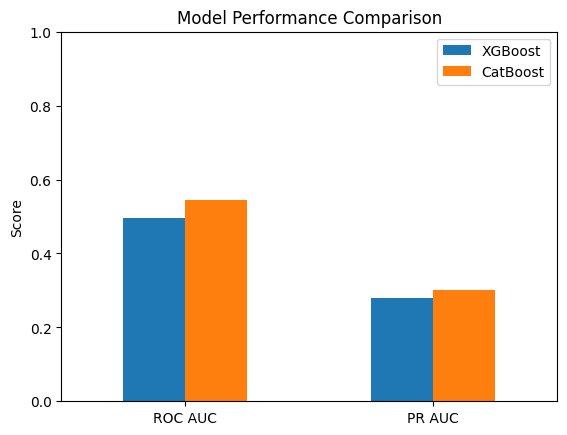

In [26]:
# Compare all tuned models (assuming you have already tuned XGBoost and now CatBoost)
model_comparison = pd.DataFrame({
    'XGBoost': {
        'ROC AUC': roc_auc_xgb,
        'PR AUC': pr_auc_xgb,
        'F1 Score (Class 1)': classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score']
    },
    'CatBoost': {
        'ROC AUC': roc_auc_catboost,
        'PR AUC': pr_auc_catboost,
        'F1 Score (Class 1)': classification_report(y_test, y_pred_catboost, output_dict=True)['1']['f1-score']
    }
})

print("Model Performance Comparison:")
print(model_comparison)

# Visualize model comparison
plt.figure(figsize=(10, 6))
model_comparison.loc[['ROC AUC', 'PR AUC']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

In [30]:
import joblib
import json
import os # To ensure the directory exists

# --- Define the models dictionary (assuming they are trained) ---
# models = {
#     "Random Forest": rf_clf,
#     "XGBoost": xgb_clf,
#     "CatBoost": cat_clf
# }

# --- Define performance results dictionary (assuming it exists) ---
# results = {
#     "Random Forest": {'roc_auc': ..., 'pr_auc': ..., 'f1_score': ...},
#     "XGBoost": {'roc_auc': ..., 'pr_auc': ..., 'f1_score': ...},
#     "CatBoost": {'roc_auc': ..., 'pr_auc': ..., 'f1_score': ...}
# }

# --- Define output directory ---
output_dir = "streamlit_artifacts"
os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist

# --- Save the models ---
model_paths = {}
for name, model in models.items():
    filename = f"{name.lower().replace(' ', '_')}_model.joblib"
    filepath = os.path.join(output_dir, filename)
    joblib.dump(model, filepath)
    model_paths[name] = filepath # Store path for potential future use
    print(f"Model '{name}' saved to {filepath}")

# --- Save the Scaler ---
scaler_path = os.path.join(output_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# --- Save the Training Columns ---
columns_path = os.path.join(output_dir, 'training_columns.json')
training_columns = X_train.columns.tolist()
with open(columns_path, 'w') as f:
    json.dump(training_columns, f)
print(f"Training columns saved to {columns_path}")

# --- Save Unique Categorical Values ---
cat_values_path = os.path.join(output_dir, 'categorical_values.json')
original_categorical_cols = ['location', 'weather_condition', 'geopolitical_event', 'terrain_type']
categorical_values = {}
for col in original_categorical_cols:
    unique_vals = df[col].dropna().unique().tolist()
    categorical_values[col] = sorted(unique_vals)
with open(cat_values_path, 'w') as f:
    json.dump(categorical_values, f)
print(f"Categorical values saved to {cat_values_path}")

# --- Save Performance Metrics for all models ---
metrics_path = os.path.join(output_dir, 'all_model_performance.json')
all_performance = {}
for name, metrics in results.items():
     # Ensure you extract the correct f1-score key if nested
     f1_positive = metrics.get('f1_score', 0) # Default to 0 if not found directly
     if isinstance(metrics.get('classification_report'), dict): # Check if full report dict is stored
          f1_positive = metrics['classification_report'].get('1', {}).get('f1-score', 0)

     all_performance[name] = {
         'model_name': name,
         'roc_auc': metrics.get('roc_auc', 0),
         'pr_auc': metrics.get('pr_auc', 0),
         'f1_score_positive_class': f1_positive
     }
with open(metrics_path, 'w') as f:
    json.dump(all_performance, f, indent=4) # Use indent for readability
print(f"All model performance metrics saved to {metrics_path}")

# --- Save list of numerical columns requiring scaling ---
num_cols_path = os.path.join(output_dir, 'numerical_cols_to_scale.json')
with open(num_cols_path, 'w') as f:
    json.dump(numerical_cols_to_scale, f)
print(f"Numerical columns to scale saved to {num_cols_path}")

Model 'Random Forest' saved to streamlit_artifacts\random_forest_model.joblib
Model 'SVM' saved to streamlit_artifacts\svm_model.joblib
Model 'XGBoost' saved to streamlit_artifacts\xgboost_model.joblib
Model 'LightGBM' saved to streamlit_artifacts\lightgbm_model.joblib
Model 'CatBoost' saved to streamlit_artifacts\catboost_model.joblib
Scaler saved to streamlit_artifacts\scaler.joblib
Training columns saved to streamlit_artifacts\training_columns.json
Categorical values saved to streamlit_artifacts\categorical_values.json
All model performance metrics saved to streamlit_artifacts\all_model_performance.json
Numerical columns to scale saved to streamlit_artifacts\numerical_cols_to_scale.json


In [28]:
import numpy
import sklearn
import joblib
import pandas # Add others if relevant (xgboost, lightgbm, catboost)

print(f"NumPy version (Notebook): {numpy.__version__}")
print(f"Scikit-learn version (Notebook): {sklearn.__version__}")
print(f"Joblib version (Notebook): {joblib.__version__}")
print(f"Pandas version (Notebook): {pandas.__version__}")
# Add print statements for xgboost.__version__, etc., if you used them directly

NumPy version (Notebook): 2.0.2
Scikit-learn version (Notebook): 1.6.1
Joblib version (Notebook): 1.4.2
Pandas version (Notebook): 2.2.3


In [29]:
# check_versions.py
import numpy
import sklearn
import joblib
import pandas
import sys
# import xgboost # uncomment if used
# import lightgbm # uncomment if used
# import catboost # uncomment if used

print(f"Python version: {sys.version}")
print(f"NumPy version (Streamlit Env): {numpy.__version__}")
print(f"Scikit-learn version (Streamlit Env): {sklearn.__version__}")
print(f"Joblib version (Streamlit Env): {joblib.__version__}")
print(f"Pandas version (Streamlit Env): {pandas.__version__}")
# print(f"XGBoost version (Streamlit Env): {xgboost.__version__}") # uncomment
# print(f"LightGBM version (Streamlit Env): {lightgbm.__version__}") # uncomment
# print(f"CatBoost version (Streamlit Env): {catboost.__version__}") # uncomment

Python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
NumPy version (Streamlit Env): 2.0.2
Scikit-learn version (Streamlit Env): 1.6.1
Joblib version (Streamlit Env): 1.4.2
Pandas version (Streamlit Env): 2.2.3
